Train size: 6862
Eval  size (2020–2023): 1434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1382
[LightGBM] [Info] Number of data points in the train set: 6862, number of used features: 7
[LightGBM] [Info] Start training from score 16596.726468
LightGBM R² on 2013–2023: 0.9927
XGBoost  R² on 2013–2023: 0.9938


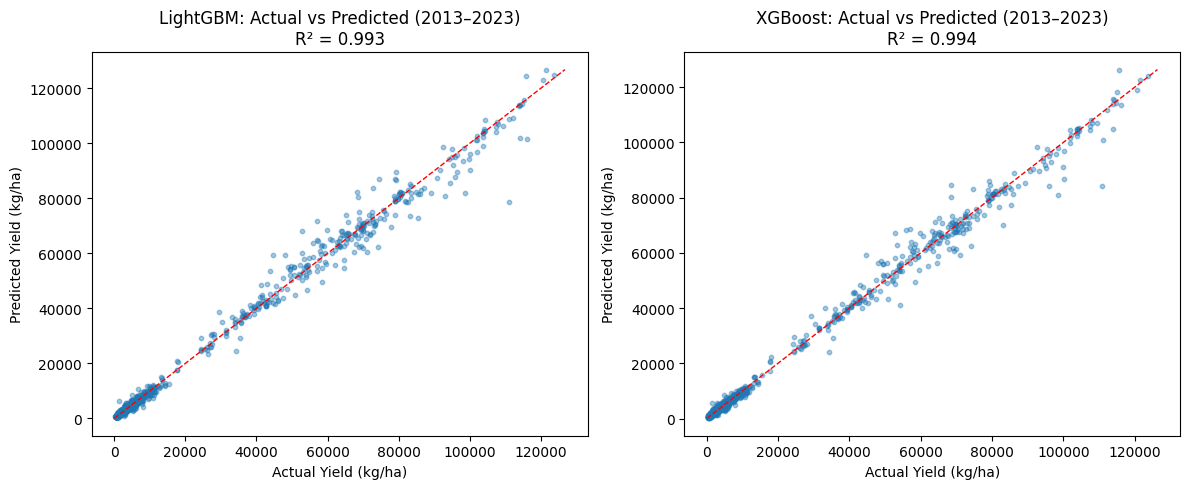

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

df = pd.read_csv("data/yield_climate_final.csv")
df['year'] = df['year'].astype(int)
df = df.dropna(subset=['lag_yield_kg_ha'])


feature_cols = [
    't2m',
    'precip',
    'rad',
    'rh2m',
    'lag_yield_kg_ha',
    'crop_encoded',
    'country_encoded'
]

target_col = 'yield_kg_ha'

X = df[feature_cols]
y = df[target_col]

# -----------------------------
#  Time-based split
#    - Train: 2002–2012
#    - Evaluate/plot: 2013–2023
# -----------------------------
train_mask = df['year'] <= 2020
eval_mask  = df['year'] >= 2020 

X_train = X[train_mask]
y_train = y[train_mask]

X_eval  = X[eval_mask]
y_eval  = y[eval_mask]

print("Train size:", len(X_train))
print("Eval  size (2020–2023):", len(X_eval))

# -----------------------------
# Define models
# -----------------------------
lgbm = LGBMRegressor(
    n_estimators=700,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb = XGBRegressor(
    n_estimators=700,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=6,
    tree_method="hist",
    random_state=42
)

# -----------------------------
#  Train models
# -----------------------------
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# -----------------------------
#  Predict for 2013–2023
# -----------------------------
y_pred_lgbm = lgbm.predict(X_eval)
y_pred_xgb  = xgb.predict(X_eval)

r2_lgbm = r2_score(y_eval, y_pred_lgbm)
r2_xgb  = r2_score(y_eval, y_pred_xgb)

print(f"LightGBM R² on 2013–2023: {r2_lgbm:.4f}")
print(f"XGBoost  R² on 2013–2023: {r2_xgb:.4f}")

# -----------------------------
#  Plot Actual vs Predicted
#    (scatter, side by side)
# -----------------------------
plt.figure(figsize=(12, 5))

# LightGBM
plt.subplot(1, 2, 1)
plt.scatter(y_eval, y_pred_lgbm, alpha=0.4, s=10)
min_val = min(y_eval.min(), y_pred_lgbm.min())
max_val = max(y_eval.max(), y_pred_lgbm.max())
plt.plot([min_val, max_val], [min_val, max_val],
         color='red', linestyle='--', linewidth=1)
plt.xlabel("Actual Yield (kg/ha)")
plt.ylabel("Predicted Yield (kg/ha)")
plt.title(f"LightGBM: Actual vs Predicted (2013–2023)\nR² = {r2_lgbm:.3f}")

# XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_eval, y_pred_xgb, alpha=0.4, s=10)
min_val = min(y_eval.min(), y_pred_xgb.min())
max_val = max(y_eval.max(), y_pred_xgb.max())
plt.plot([min_val, max_val], [min_val, max_val],
         color='red', linestyle='--', linewidth=1)
plt.xlabel("Actual Yield (kg/ha)")
plt.ylabel("Predicted Yield (kg/ha)")
plt.title(f"XGBoost: Actual vs Predicted (2013–2023)\nR² = {r2_xgb:.3f}")

plt.tight_layout()
plt.savefig("actual_vs_predicted_2013_2023.png", dpi=300)
plt.show()
